In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

%matplotlib inline

/Users/anthony-mba/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# player_url = "Curry_Stephen"
# player_url = "Thompson_Klay"
# player_url = "Durant_Kevin"
# player_url = "Green_Draymond"
# player_url = "James_LeBron"
# player_url = "DeRozan_DeMar"
# player_url = "Westbrook_Russell"
# player_url = "Gobert_Rudy"
# player_url = "Mills_Patty"
# player_url = "Simmons_Jonathon"

player_url = "Draymond_Green"
opp_team = "SAS"
last_x_games = -5
playoff_game = 1

In [3]:
def get_player_prediction(model, seed):
#     print model.predict(seed).mean()
    return model.predict(seed).mean()

In [4]:
def get_seed_data(X_test, cols, random_data_rows=1, home_game=1, playoff_game=1, game_started=1):
    # randomly seeding data based on mean/std from a given opponent
    seed = []
    for i in range(random_data_rows):
        row = []
        for col in cols:
            if col == "Home_Game":
                row.append(home_game) # home game == 1, away game == 0
    #             row.append(np.random.choice([0,1]))
            elif col == 'gs':
                row.append(game_started)
            elif col == 'playoff_game':
                row.append(playoff_game)
            else:    
                std = X_test[col].std()
                if std == 0:
                    row.append(0)
                else:
                    row.append(X_test[col].mean())
#                     row.append(np.random.normal(X_test[col].mean(), X_test[col].std()))
        seed.append(row)
    
#     print ridge.score(X_test, y_test)
    seed = pd.DataFrame(seed, columns=cols)
    
    return seed

In [5]:
def get_model(X_train, X_test, y_train, y_test):
    model = RidgeCV().fit(X_train, y_train)
#     print model.score(X_train, y_train)
#     print model.score(X_test, y_test)
    return model

In [6]:
def set_train_test_split(opp_team, last_x_games, playoff_game, df, cols):
#     Xs = StandardScaler().fit_transform(df[cols])
#     Xs = pd.DataFrame(Xs, columns=X.columns)
    
    # setting opponents mask
    opponents = pd.concat([df[(df['opp'] == opp_team)], df[last_x_games:]])#['pts'] # df['playoff'] == playoff_game
    # setting testing data based on team opponent and last 5 games
    mask = opponents.index.values
    
    # setting training data as all data from player
    X_train = df[cols]
    y_train = df[['pts']]
    X_test = df.ix[mask,:][cols]
    y_test = df.ix[mask,:][['pts']]
    
    return (X_train, X_test, y_train, y_test)

In [7]:
def get_data(player_url):
    # setting empty dataframe
    df = pd.DataFrame()
    
    # retreiving data from csv files
    for file in os.listdir("./basketball_reference/game_logs/"):
        if file.startswith(player_url):
            filepath = "./basketball_reference/game_logs/" + file
            print filepath
            data = pd.read_csv(filepath)
            df = df.append(data)
    
    df = df.reset_index()
    
    # deleting unnecessary or columns with NAN
    del df['index']
    del df['fg_pct']
    del df['fg3_pct']
    del df['ft_pct']
    # del df['orb_pct']
    # del df['plus_minus']
    
    # data cleaning for all game_log files
    df['date'] = pd.to_datetime(df['date'])
    df.rename(columns={'loc': 'Home_Game'}, inplace=True)
    df['playoff'] = [0 if item[-1] == "N" else 1 for item in df['playoff']]
    df['Home_Game'] = [0 if item == "@" else 1 for item in df['Home_Game']]
    df['result'] = [item[3:].replace(")","") for item in df['result']]
    df['result'] = df['result'].astype(float)
    df['mp'] = [0 if pd.isnull(item) else round(float(item.split(":")[0]) + float(item.split(":")[1])/60. , 2) for item in df['mp']]
    # df['playoff'] = df['playoff'].map(lambda x: x[-1])
    
    df = df.dropna(axis=0, how='any')
    
    return df

In [9]:
def predict_player(player_url='Kevin_Durant', opp_team="SAS", last_x_games=-5, playoff_game=1):
    df = get_data(player_url)

    # setting wanted columns for dataframe
    cols = list(df.columns.values[6:-1])
    cols = [col for col in cols if col not in ['fg_pct','fg3_pct','ft_pct','pts']] + ['Home_Game', 'playoff']
    
    # setting training data as all data from player
    X_train, X_test, y_train, y_test = set_train_test_split(opp_team, last_x_games, playoff_game, df, cols)
    
    model = get_model(X_train, X_test, y_train, y_test)
    
#     print get_seed_data(X_test, cols)
    
    predicted_ppg = get_player_prediction(model, get_seed_data(X_test, cols))
    
    return (predicted_ppg, X_test['mp'].mean())

print predict_player(player_url)

./basketball_reference/game_logs/Draymond_Green_2015.csv
./basketball_reference/game_logs/Draymond_Green_2016.csv
./basketball_reference/game_logs/Draymond_Green_2017.csv
(11.875091663321253, 33.026875000000004)


In [10]:
get_data(player_url)

./basketball_reference/game_logs/Draymond_Green_2015.csv
./basketball_reference/game_logs/Draymond_Green_2016.csv
./basketball_reference/game_logs/Draymond_Green_2017.csv


,game,playoff,date,team,Home_Game,opp,result,gs,mp,fg,...,drb_pct,trb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg_pct,off_rtg,def_rtg,Name
0,1,0,2014-10-29,GSW,0,SAC,18.0,1,34.37,4,...,21.5,14.9,15.3,1.4,0.0,36.3,17.3,91,76,Draymond Green
1,2,0,2014-11-01,GSW,1,LAL,23.0,1,30.48,3,...,13.1,9.8,3.8,1.6,0.0,9.2,14.9,106,104,Draymond Green
2,3,0,2014-11-02,GSW,0,POR,5.0,1,29.23,2,...,19.3,10.2,10.0,3.4,2.5,10.7,14.3,64,86,Draymond Green
3,4,0,2014-11-05,GSW,1,LAC,17.0,1,35.67,8,...,26.9,15.6,20.9,1.3,2.1,21.3,23.9,128,101,Draymond Green
4,5,0,2014-11-08,GSW,0,HOU,11.0,1,34.15,6,...,15.3,11.2,9.2,1.4,6.4,22.4,20.9,88,87,Draymond Green
5,6,0,2014-11-09,GSW,0,PHO,-12.0,1,35.93,7,...,25.4,16.0,0.0,1.3,10.9,23.6,27.2,100,99,Draymond Green
6,7,0,2014-11-11,GSW,1,SAS,-13.0,1,31.70,2,...,13.5,8.2,21.6,0.0,2.2,10.2,15.1,110,118,Draymond Green
7,8,0,2014-11-13,GSW,1,BRK,8.0,1,32.63,7,...,31.0,13.7,33.5,1.5,4.0,6.7,20.2,128,99,Draymond Green
8,9,0,2014-11-15,GSW,1,CHO,25.0,1,29.28,3,...,16.4,10.7,8.2,0.0,0.0,20.0,15.3,85,95,Draymond Green
9,10,0,2014-11-16,GSW,0,LAL,21.0,1,24.00,4,...,26.7,16.2,5.3,0.0,0.0,0.0,8.5,194,107,Draymond Green


In [11]:
data = get_data(player_url)

./basketball_reference/game_logs/Draymond_Green_2015.csv
./basketball_reference/game_logs/Draymond_Green_2016.csv
./basketball_reference/game_logs/Draymond_Green_2017.csv


./basketball_reference/game_logs/Draymond_Green_2015.csv
./basketball_reference/game_logs/Draymond_Green_2016.csv
./basketball_reference/game_logs/Draymond_Green_2017.csv


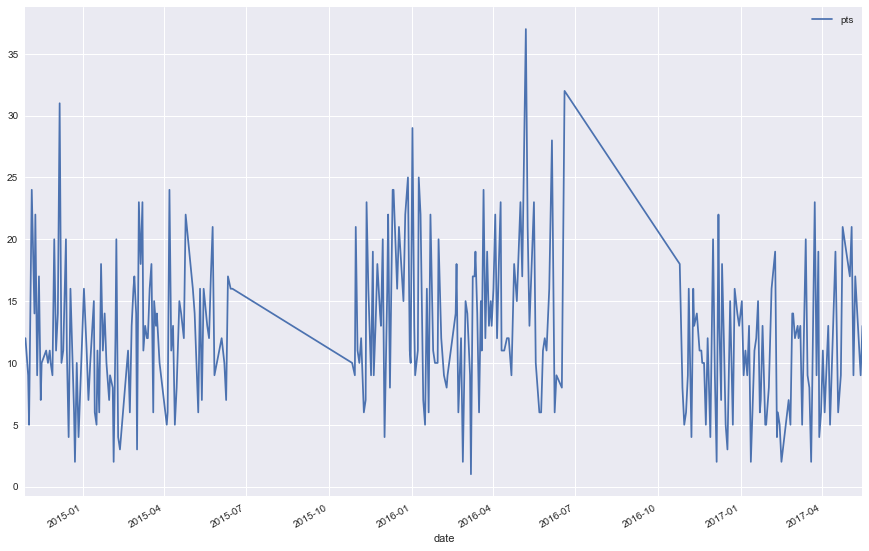

In [13]:
# fig, ax = plt.subplots(figsize)
get_data(player_url).plot(x='date', y='pts', figsize=(15, 10))